In [352]:
import pandas as pd
import numpy as np
import os
import calendar
import proplot
import matplotlib.pyplot as plt
from scipy.stats import linregress
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio   
pio.kaleido.scope.mathjax = None
import warnings
warnings.filterwarnings('ignore')
os.chdir('/Users/zeqinhuang/Documents/paper/acid_rain')

# calculate the characteristics of acid rain events

In [227]:
acid_rain_df = pd.DataFrame()
month_dict = {index: month for index, month in enumerate(calendar.month_abbr) if month}
ar_stns = pd.read_csv('ACID_RAIN_DATA/acid_rain_station.csv',header=0,index_col=0)
ar_stns = ar_stns[ar_stns.index!='Xiangzhou'] # acid rain data in Xiangzhou station is not available

for stn in ar_stns.index:
    ar_stn = pd.read_csv('ACID_RAIN_DATA/acid_rain_' + stn + '.csv',index_col=0)
    ar_stn.index = pd.to_datetime(ar_stn.index)
    for y in range(2001,2022):
        for m in range(1,13):
            ar_sel = ar_stn[(ar_stn.index.year==y) & (ar_stn.index.month==m)]
            rain_freq = len(ar_sel)
            acid_freq = len(ar_sel[ar_sel['pH']<=5.6])
            total_rain = ar_sel['Rain_amount'].sum(skipna=True)
            mean_pH = ar_sel['pH'].mean(skipna=True)
            mean_conductivity = ar_sel['conductivity'].mean(skipna=True)
            mean_SO = ar_sel['SO42-'].mean(skipna=True)
            mean_NO = ar_sel['NO3-'].mean(skipna=True)
            mean_F = ar_sel['F-'].mean(skipna=True)
            mean_Cl = ar_sel['Cl-'].mean(skipna=True)
            mean_NH4 = ar_sel['NH4+'].mean(skipna=True)
            mean_Ca2 = ar_sel['Ca2+'].mean(skipna=True)
            mean_Mg2 = ar_sel['Mg2+'].mean(skipna=True)
            mean_Na = ar_sel['Na+'].mean(skipna=True)
            mean_K = ar_sel['K+'].mean(skipna=True)
            if rain_freq > 0:
                acid_perc = acid_freq / rain_freq
            else:
                acid_perc = None
            df_stn_y_m = pd.DataFrame(
                {
                    'station':stn,'year':[y],'month':[month_dict[m]],'rain_freq':[rain_freq],'acid_freq':[acid_freq],
                    'total_rain':[total_rain],'mean_pH':[mean_pH],'mean_conductivity':[mean_conductivity],
                    'mean_SO':[mean_SO], 'mean_NO':[mean_NO], 'mean_F':[mean_F],'mean_Cl':[mean_Cl],
                    'mean_NH4':[mean_NH4],'mean_Ca2':[mean_Ca2],'mean_Mg2':[mean_Mg2],'mean_Na':[mean_Na],
                    'mean_K':[mean_K],'acid_perc':[acid_perc],
                })
            acid_rain_df = pd.concat([acid_rain_df,df_stn_y_m],axis=0)
acid_rain_df.index = range(len(acid_rain_df))
acid_rain_df.to_csv('ACID_RAIN_DATA/acid_rain_characteristics.csv')

# bar_polar illustrating the seasonal distribution of acid rain percentages (with pH values < 5.6)

## bar_polar plot for an instance

In [228]:
fig = px.bar_polar(acid_rain_df[acid_rain_df['station']=='Yuexiu'], r="acid_perc", theta="month",
                color="year", 
                color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.show()

## save bar_polar plots for each station

In [229]:
indices = [i for i in 'abcdefghijklmnopqrstuvwxyz']
indices.append('aa')
indices.append('bb')
stn_index = {stn:index for (stn,index) in zip(ar_stns.index,indices)}
for stn in ar_stns.index:
    if stn == ar_stns.index[-1]:
        fig = px.bar_polar(acid_rain_df[acid_rain_df['station']==stn], r="acid_perc", theta="month",
                            color="year", width=600,height=400, range_r=[0,14],
                            color_discrete_sequence= px.colors.sequential.Plasma_r)
        fig.update(layout_coloraxis_showscale=True)
    else:
        fig = px.bar_polar(acid_rain_df[acid_rain_df['station']==stn], r="acid_perc", theta="month",
                        color="year", width=400,height=400, range_r=[0,14],
                        color_discrete_sequence= px.colors.sequential.Plasma_r)
        fig.update(layout_coloraxis_showscale=False)
    fig.update_layout(showlegend=False)
    fig.update_layout(
        {
            "plot_bgcolor": "rgba(0, 0, 0, 0)",
            "margin":{"l":50,"r":50,"t":50,"b":50}
        })
    fig.update_layout(
                font_size=18,
                title={
                'text' : stn,
                'x':0.5,
                'xanchor': 'center'
            })
    if stn == ar_stns.index[-1]:
        fig.update_layout(
            annotations=[
                dict(
                    text=stn_index[stn],
                    showarrow=False,
                    xref="paper",
                    yref="paper",
                    font_size=22,
                    x=0.1,
                    y=1.1)
            ])
    else:
        fig.update_layout(
            annotations=[
                dict(
                    text=stn_index[stn],
                    showarrow=False,
                    xref="paper",
                    yref="paper",
                    font_size=22,
                    x=-0.1,
                    y=1.1)
            ])
    # fig.show()
    fig.write_image('/Users/zeqinhuang/Documents/paper/acid_rain/Figures/bar_polar_for_acid_rain_percentage/station_'+ stn + '.pdf')

## save bar_polar plots for each city

In [175]:
cities = np.unique(ar_stns['City'])

for c in cities:
    stn_sel = ar_stns[ar_stns['City']==c].index
    ar_city = acid_rain_df[acid_rain_df['station'].isin(stn_sel)]
    ar_city = ar_city.drop(columns=['station'])
    ar_city = ar_city.groupby(['year','month']).agg({lambda x: x.mean(skipna=True)})
    ar_city['year'] = [i[0] for i in ar_city.index]
    ar_city['month'] = [i[1] for i in ar_city.index]
    ar_city.columns = [i[0] for i in ar_city.columns]
    ar_city = ar_city.reindex(list(month_dict.values()),level=1) # reindex from Jan to Dec

    if c == '#Shenzhen':
        fig = px.bar_polar(ar_city, r="acid_perc", theta="month",
                            color="year", width=600,height=400, range_r=[0,14],
                            color_discrete_sequence= px.colors.sequential.Plasma_r)
        fig.update(layout_coloraxis_showscale=True)
    else:
        fig = px.bar_polar(ar_city, r="acid_perc", theta="month",
                        color="year", width=400,height=400, range_r=[0,14],
                        color_discrete_sequence= px.colors.sequential.Plasma_r)
        fig.update(layout_coloraxis_showscale=False)
    fig.update_layout(
        {
            "plot_bgcolor": "rgba(0, 0, 0, 0)",
            "margin":{"l":40,"r":40,"t":40,"b":40}
        })
    fig.update_layout(
            font_size=20
        )
    fig.update_layout(
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)"
    )

    # if c == '#Shenzhen':
    #     fig.update_layout(
    #             font_size=18,
    #             title={
    #             'text' : c,
    #             'x':0.45,
    #             'y':0.97,
    #             'xanchor': 'center',
    #             'yanchor': 'middle'
    #         })
    # else:
    #     fig.update_layout(
    #             font_size=18,
    #             title={
    #             'text' : c,
    #             'x':0.5,
    #             'y':0.97,
    #             'xanchor': 'center',
    #             'yanchor': 'middle'
    #         })
    # fig.show()
    fig.write_image('/Users/zeqinhuang/Documents/paper/acid_rain/Figures/bar_polar_for_acid_rain_percentage/city_'+ c + '.svg')

## save bar_polar plot for GBA

In [171]:
cities = np.unique(ar_stns['City'])

ar_cities = pd.DataFrame()
for c in cities:
    stn_sel = ar_stns[ar_stns['City']==c].index
    ar_city = acid_rain_df[acid_rain_df['station'].isin(stn_sel)]
    ar_city = ar_city.drop(columns=['station'])
    ar_city = ar_city.groupby(['year','month']).agg({lambda x: x.mean(skipna=True)})
    # ar_city['year'] = [i[0] for i in ar_city.index]
    # ar_city['month'] = [i[1] for i in ar_city.index]
    ar_city.columns = [i[0] for i in ar_city.columns]
    # ar_city['city'] = c
    ar_cities = pd.concat([ar_cities, ar_city], axis=0)

ar_cities = ar_cities.groupby(['year','month']).agg({lambda x: x.mean(skipna=True)})
ar_cities['year'] = [i[0] for i in ar_cities.index]
ar_cities['month'] = [i[1] for i in ar_cities.index]
ar_cities.columns = [i[0] for i in ar_cities.columns]
ar_cities = ar_cities.reindex(list(month_dict.values()),level=1) # reindex from Jan to Dec

fig = px.bar_polar(ar_cities, r="acid_perc", theta="month",
                            color="year", width=400,height=500, range_r=[0,12],
                            color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update(layout_coloraxis_showscale=True)
fig.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "margin":{"l":0,"r":0,"t":80,"b":100}
    })
fig.update_layout(
        font_size=18,
        title={
        'text' : 'Greater Bay Area',
        'x':0.5,
        'y':0.97,
        'xanchor': 'center',
        'yanchor': 'middle'
    })
fig.update_coloraxes(colorbar={'orientation':'h', 'thickness':20, 'y': -0.45, 'title_side':'top'})
fig.show()

fig.write_image('/Users/zeqinhuang/Documents/paper/acid_rain/Figures/bar_polar_for_acid_rain_percentage/GBA_acid_rain_percentage.pdf')

# changes of pH of individual rain event and annual changes in acid rain characteristcs (pH, conductivity, SO42-, NO3-)

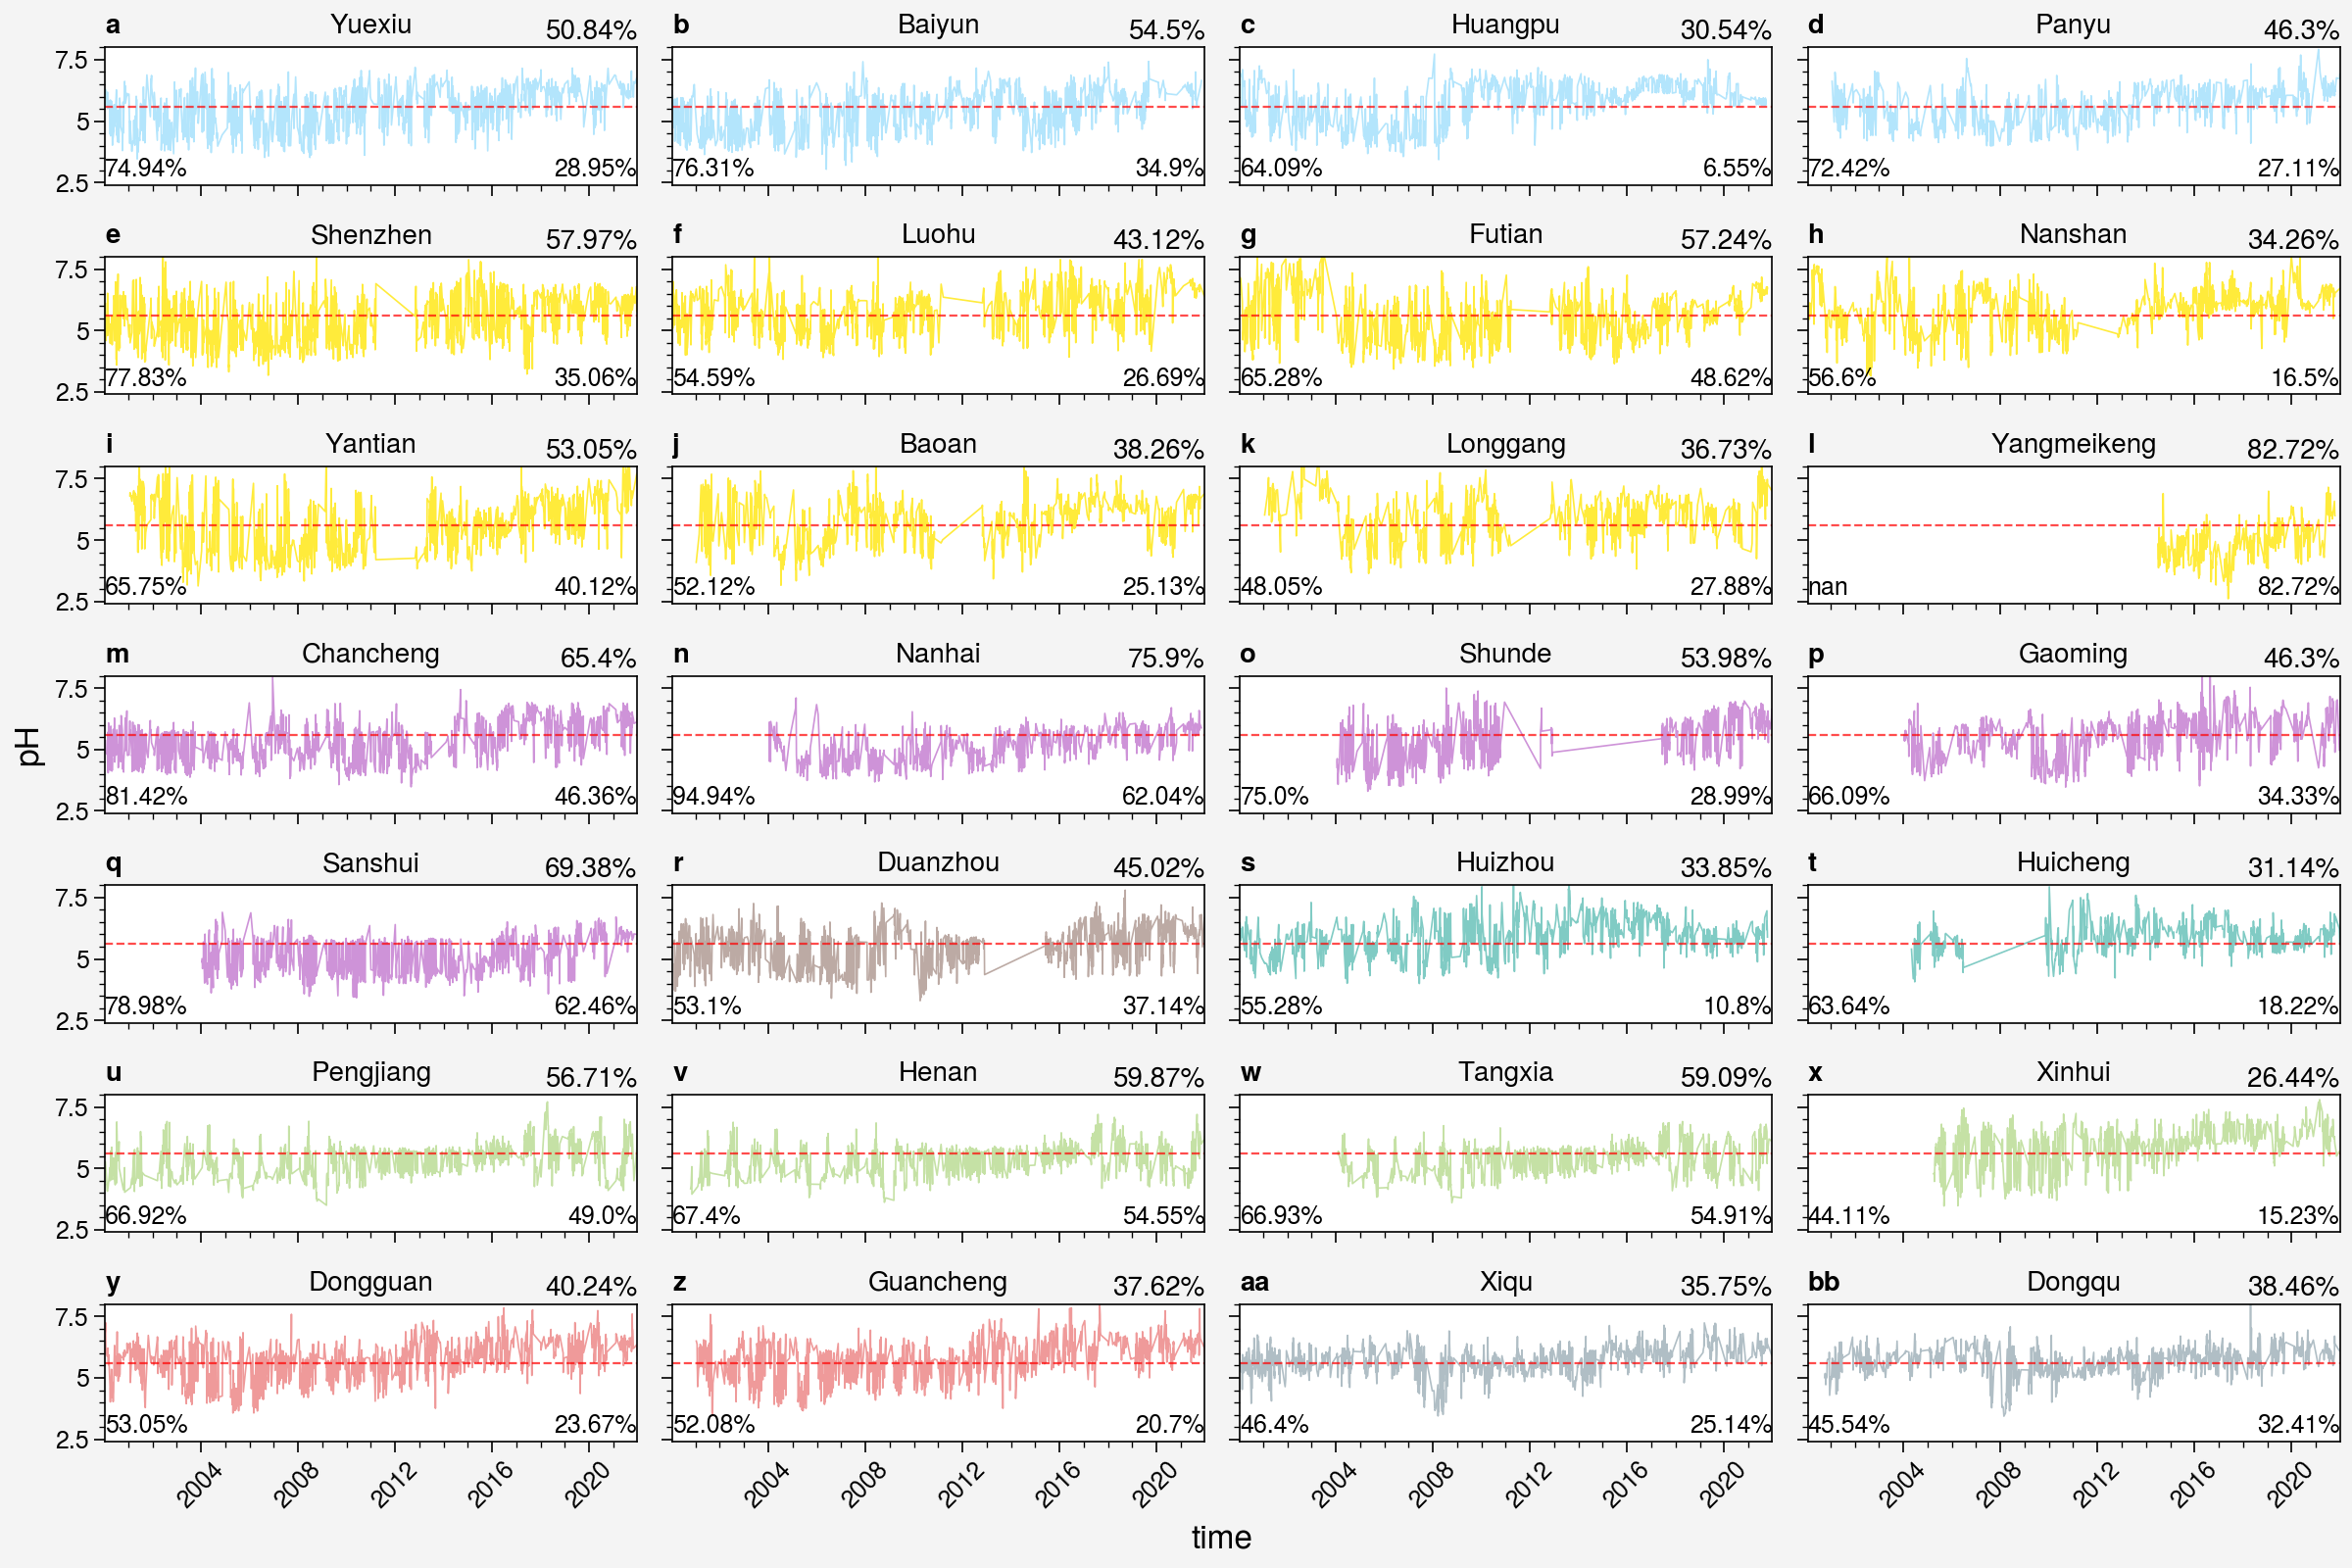

In [411]:
stn_city = {s:ar_stns[ar_stns.index==s]['City'].values[0] for s in ar_stns.index}
cities = list(cities)
city_colors = ['#EF9A9A','#CE93D8','#B3E5FC','#80CBC4','#C5E1A5','#FFEB3B','#BCAAA4','#B0BEC5']
proplot.rc['formatter.timerotation'] = 'horizontal'
def add_panel_label(ax, label, x = -0.1, y = 1, fontsize=10):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=fontsize,  va='bottom', ha='right') #fontweight='bold',
def add_panel_label2(ax, label, x = -0.1, y = 1, fontsize=10):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=fontsize,  va='bottom', ha='left') #fontweight='bold',

fig, axs = proplot.subplots(ncols=4, nrows=7, figsize=(12,8),sharey=3)

for i in range(len(ar_stns.index)):
    stn = ar_stns.index[i]
    city = stn_city[stn]
    ar_stn = pd.read_csv('ACID_RAIN_DATA/acid_rain_' + stn + '.csv',index_col=0)
    ar_stn.index = pd.to_datetime(ar_stn.index)
    ar_stn_bef = ar_stn[ar_stn.index < '2011-01-01']
    ar_stn_aft = ar_stn[ar_stn.index >= '2011-01-01']
    rain_freq = len(ar_stn)
    acid_freq = len(ar_stn[ar_stn['pH']<=5.6])
    rain_freq_bef = len(ar_stn_bef)
    acid_freq_bef = len(ar_stn_bef[ar_stn_bef['pH']<=5.6])
    rain_freq_aft = len(ar_stn_aft)
    acid_freq_aft = len(ar_stn_aft[ar_stn_aft['pH']<=5.6])
    ar_percent = round(acid_freq / rain_freq * 100, 2)
    try:
        ar_percent_bef = round(acid_freq_bef / rain_freq_bef * 100, 2)
    except:
        ar_percent_bef = np.nan
    ar_percent_aft = round(acid_freq_aft / rain_freq_aft * 100, 2)
    city_index = cities.index(city)
    axs[i].plot(ar_stn['pH'], linewidth=0.6, color=city_colors[city_index])
    axs[i].grid(False)
    axs[i].axhline(y=5.6, color='red', alpha=0.7, linewidth=0.8, linestyle='--')
    axs[i].set(ylim=(2.4,8))
    axs[i].xaxis.set_tick_params(rotation=45)
    axs[i].set_title(stn,fontdict={'fontsize':10,'fontweight': 'medium'})
    add_panel_label(axs[i], str(ar_percent)+'%', x=1, y = 1.02)
    if np.isnan(ar_percent_bef):
        add_panel_label2(axs[i], str(ar_percent_bef), x=0, y = 0.02, fontsize=9)
    else:
        add_panel_label2(axs[i], str(ar_percent_bef)+'%', x=0, y = 0.02, fontsize=9)
    add_panel_label(axs[i], str(ar_percent_aft)+'%', x=1, y = 0.02, fontsize=9)

axs.format(abc='a',abcloc='l')
axs.format(xlabel_kw={'fontsize':12,'fontweight':'medium'})
axs.format(ylabel_kw={'fontsize':12,'fontweight':'medium'})

fig_dir = '/Users/zeqinhuang/Documents/paper/acid_rain/Figures/'
fig.savefig(fig_dir+'Fig2_pH_distribution_for_individual_event_at_each_station.pdf')
fig.savefig(fig_dir+'Fig2_pH_distribution_for_individual_event_at_each_station.png')

In [296]:
cities = np.unique(ar_stns['City'])
cities_list = cities.tolist()
cities_list.append('GBA')
acid_rain_city_pH_annual = {}
acid_rain_city_conductivity_annual = {}
acid_rain_city_SO4_annual = {}
acid_rain_city_NO3_annual = {}

for c in cities_list:
    acid_rain_city_pH = pd.DataFrame()
    acid_rain_city_conductivity = pd.DataFrame()
    acid_rain_city_SO4 = pd.DataFrame()
    acid_rain_city_NO3 = pd.DataFrame()

    if c != 'GBA':
        stn_sel = ar_stns[ar_stns['City']==c].index
    else:
        stn_sel = ar_stns.index
    for stn in stn_sel:
        ar_stn = pd.read_csv('ACID_RAIN_DATA/acid_rain_' + stn + '.csv',index_col=0)
        ar_stn.index = pd.to_datetime(ar_stn.index)
        acid_rain_city_pH = pd.concat([acid_rain_city_pH, ar_stn['pH'].groupby(ar_stn.index.year).agg({lambda x: x.mean(skipna=True)})], axis=1)
        acid_rain_city_conductivity = pd.concat([acid_rain_city_conductivity, ar_stn['conductivity'].groupby(ar_stn.index.year).agg({lambda x: x.mean(skipna=True)})], axis=1)
        acid_rain_city_SO4 = pd.concat([acid_rain_city_SO4, ar_stn['SO42-'].groupby(ar_stn.index.year).agg({lambda x: x.mean(skipna=True)})], axis=1)
        acid_rain_city_NO3 = pd.concat([acid_rain_city_NO3, ar_stn['NO3-'].groupby(ar_stn.index.year).agg({lambda x: x.mean(skipna=True)})], axis=1)
    acid_rain_city_pH.columns = stn_sel
    acid_rain_city_conductivity.columns = stn_sel
    acid_rain_city_SO4.columns = stn_sel
    acid_rain_city_NO3.columns = stn_sel

    acid_rain_city_pH[c+'_city'] = acid_rain_city_pH.mean(axis=1,skipna=True)
    acid_rain_city_conductivity[c+'_city'] = acid_rain_city_conductivity.mean(axis=1,skipna=True)
    acid_rain_city_SO4[c+'_city'] = acid_rain_city_SO4.mean(axis=1,skipna=True)
    acid_rain_city_NO3[c+'_city'] = acid_rain_city_NO3.mean(axis=1,skipna=True)

    acid_rain_city_pH_annual[c] = acid_rain_city_pH
    acid_rain_city_conductivity_annual[c] = acid_rain_city_conductivity
    acid_rain_city_SO4_annual[c] = acid_rain_city_SO4
    acid_rain_city_NO3_annual[c] = acid_rain_city_NO3
    

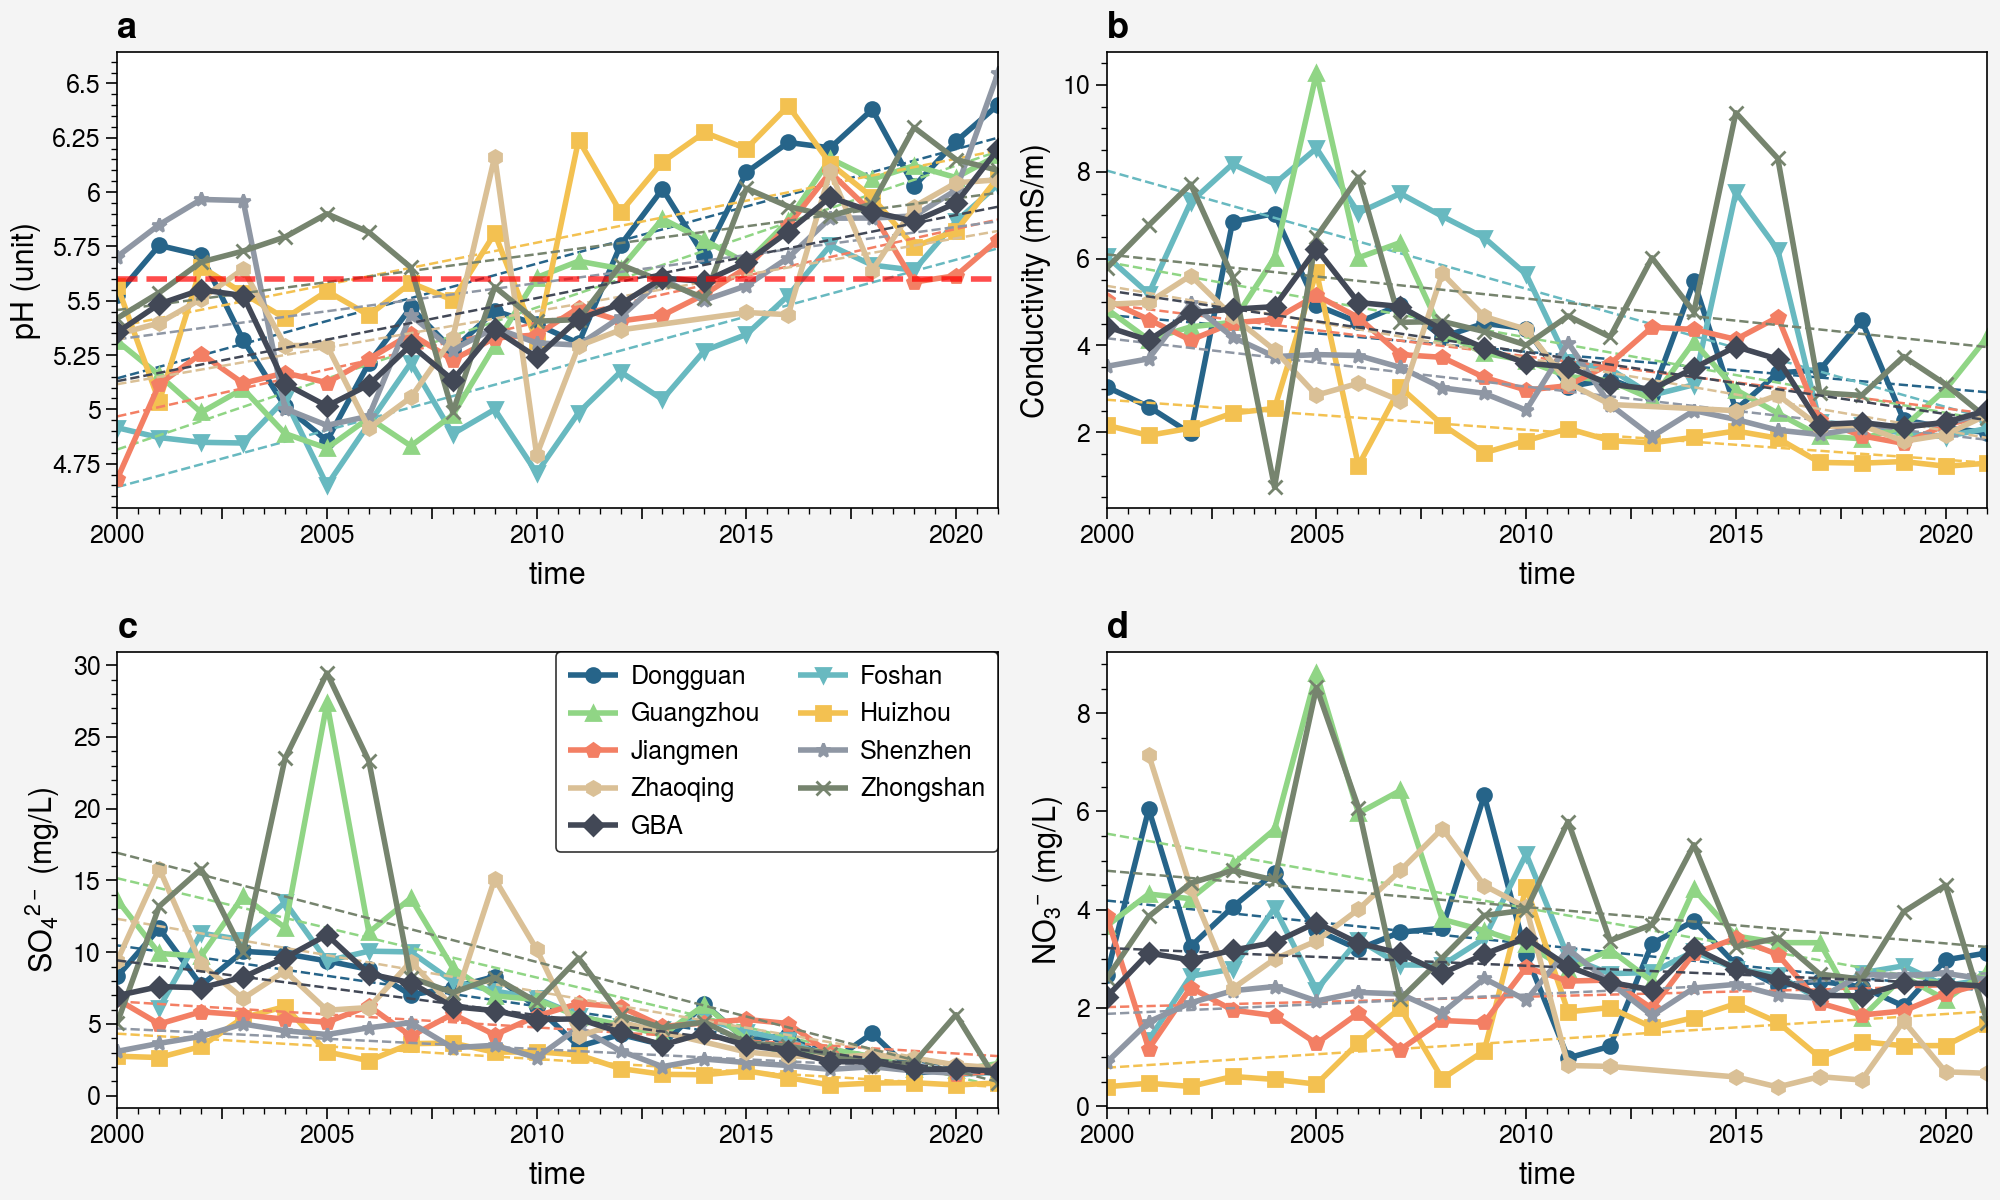

In [409]:
city_colors = ['#EF9A9A','#CE93D8','#B3E5FC','#80CBC4','#C5E1A5','#FFEB3B','#BCAAA4','#B0BEC5','black']
city_colors = ['#266489','#68B9C0','#90D585','#F3C151','#F37F64','#8F97A4','#DAC096','#76846E','#424856']
city_markers = ['o','v','^','s','p','*','h','x','D']
p_all = []
pH_slp_all  = {}
pH_pvalue_all  = {}
pH_stderr_all = {}
cond_slp_all  = {}
cond_pvalue_all  = {}
cond_stderr_all = {}
SO4_slp_all  = {}
SO4_pvalue_all  = {}
SO4_stderr_all = {}
NO3_slp_all  = {}
NO3_pvalue_all  = {}
NO3_stderr_all = {}

fig, axs = proplot.subplots(ncols=2, nrows=2, figsize=(10,6),share=0)
for i in range(len(cities_list)):
    c = cities_list[i]
    p = axs[0].plot(acid_rain_city_pH_annual[c].iloc[:,-1], color=city_colors[i], marker=city_markers[i], markersize=5, linewidth=2, alpha=1)
    axs[1].plot(acid_rain_city_conductivity_annual[c].iloc[:,-1], color=city_colors[i], marker=city_markers[i], markersize=5,linewidth=2, alpha=1)
    axs[2].plot(acid_rain_city_SO4_annual[c].iloc[:,-1], color=city_colors[i], marker=city_markers[i], markersize=5,linewidth=2, alpha=1)
    axs[3].plot(acid_rain_city_NO3_annual[c].iloc[:,-1], color=city_colors[i], marker=city_markers[i], markersize=5,linewidth=2, alpha=1)
    p_all.append(p)

    if len(acid_rain_city_pH_annual[c].iloc[:,-1]) == len(range(2000,2022)):
        x = range(2000,2022)
        y1 = acid_rain_city_pH_annual[c].iloc[:,-1]
        y2 = acid_rain_city_conductivity_annual[c].iloc[:,-1]
        y3 = acid_rain_city_SO4_annual[c].iloc[:,-1]
        y4 = acid_rain_city_NO3_annual[c].iloc[:,-1]
    else:
        len_x = len(acid_rain_city_pH_annual[c].iloc[:,-1])
        x = range(2000,2022)[-len_x:]
        y1 = acid_rain_city_pH_annual[c].iloc[:,-1][-len_x:]
        y2 = acid_rain_city_conductivity_annual[c].iloc[:,-1][-len_x:]
        y3 = acid_rain_city_SO4_annual[c].iloc[:,-1][-len_x:]
        y4 = acid_rain_city_NO3_annual[c].iloc[:,-1][-len_x:]
    pH_slp, pH_intercept, _, pH_pvalue, pH_stderr,  = linregress(x,y1)
    cond_slp, cond_intercept, _, cond_pvalue, cond_stderr,  = linregress(x,y2)
    SO4_slp, SO4_intercept, _, SO4_pvalue, SO4_stderr,  = linregress(x,y3)
    NO3_slp, NO3_intercept, _, NO3_pvalue, NO3_stderr,  = linregress(x,y4)
    pH_slp_all[c] = pH_slp
    pH_pvalue_all[c] = pH_pvalue
    pH_stderr_all[c] = pH_stderr
    cond_slp_all[c] = cond_slp
    cond_pvalue_all[c] = cond_pvalue
    cond_stderr_all[c] = cond_stderr
    SO4_slp_all[c] = SO4_slp
    SO4_pvalue_all[c] = SO4_pvalue
    SO4_stderr_all[c] = SO4_stderr
    NO3_slp_all[c] = NO3_slp
    NO3_pvalue_all[c] = NO3_pvalue
    NO3_stderr_all[c] = NO3_stderr

    axs[0].plot(np.arange(2000,2022), np.arange(2000,2022) * pH_slp + pH_intercept, color=city_colors[i], linewidth=0.9, linestyle = '--', alpha=1)
    axs[1].plot(np.arange(2000,2022), np.arange(2000,2022) * cond_slp + cond_intercept, color=city_colors[i], linewidth=0.9, linestyle = '--', alpha=1)
    axs[2].plot(np.arange(2000,2022), np.arange(2000,2022) * SO4_slp + SO4_intercept, color=city_colors[i], linewidth=0.9, linestyle = '--', alpha=1)
    axs[3].plot(np.arange(2000,2022), np.arange(2000,2022) * NO3_slp + NO3_intercept, color=city_colors[i], linewidth=0.9, linestyle = '--', alpha=1)

axs[0].axhline(y=5.6, color='red', alpha=0.7, linewidth=2, linestyle='--')
axs[0].set_ylabel('pH (unit)',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[1].set_ylabel('Conductivity (mS/m)',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[2].set_ylabel('$SO_4$$^{2-}$ (mg/L)',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[3].set_ylabel('$NO_3$$^{-}$ (mg/L)',fontdict={'fontsize':10,'fontweight': 'medium'})

axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)
axs[0].set_xticklabels([2000,None,2005,None,2010,None,2015,None,2020])
axs[1].set_xticklabels([2000,None,2005,None,2010,None,2015,None,2020])
axs[2].set_xticklabels([2000,None,2005,None,2010,None,2015,None,2020])
axs[3].set_xticklabels([2000,None,2005,None,2010,None,2015,None,2020])
axs.format(abc='a',abcloc='l',abc_kw={'fontsize':13,'fontweight':'bold'})
axs.format(xlabel_kw={'fontsize':11,'fontweight':'medium'})
axs.format(ylabel_kw={'fontsize':11,'fontweight':'medium'})

axs[2].legend(
    p_all, cities_list,fancybox = True,frameon=True, loc = 'upper right', #labelspacing = 1, #title='Legend', #bbox_to_anchor=[0.1,0.6], 
    ncol=2,fontsize=11)

fig_dir = '/Users/zeqinhuang/Documents/paper/acid_rain/Figures/'
fig.savefig(fig_dir+'Fig4_acid_rain_characteristics_stats.pdf')
fig.savefig(fig_dir+'Fig4_acid_rain_characteristics_stats.png')

In [406]:
pH_trend_stat = pd.DataFrame.from_dict(
    [pH_slp_all, pH_stderr_all, pH_pvalue_all,cond_slp_all, cond_stderr_all, cond_pvalue_all,SO4_slp_all, SO4_stderr_all, SO4_pvalue_all,NO3_slp_all, NO3_stderr_all, NO3_pvalue_all]).transpose()
pH_trend_stat.columns = ['pH_slp','pH_stderr','pH_pvalue','cond_slp','cond_stderr','cond_pvalue','SO4_slp','SO4_stderr','SO4_pvalue','NO3_slp','NO3_stderr','NO3_pvalue']
pH_trend_stat.to_csv('ACID_RAIN_DATA/acid_rain_stats_for_each_city.csv')